In [1]:
# 圣女果内部品质预测模型（基于PyTorch）

# 环境准备
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# 设置随机种子保证可重复性%%42%%
SEED =  42  #random.randint(0, 100)
print('SEED = ',SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# 检查GPU可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEED =  59
Using device: cpu


In [2]:
# 数据读取与预处理

# 读取数据
data_path = "F:/毕业论文/第三章内容/部分建模数据/部分混合建模/建模数据2.xlsx"

# 读取光谱数据
X = pd.read_excel(data_path, sheet_name='X2', header=None).values.astype(np.float32)

# 读取目标变量
Y1 = pd.read_excel(data_path, sheet_name='SSC', header=None).values.ravel().astype(np.float32)
Y2 = pd.read_excel(data_path, sheet_name='LYC', header=None).values.ravel().astype(np.float32)
Y3 = pd.read_excel(data_path, sheet_name='SSC_std', header=None).values.ravel().astype(np.float32)
Y4 = pd.read_excel(data_path, sheet_name='LYC_std', header=None).values.ravel().astype(np.float32)
Y = np.column_stack((Y1, Y2))

Q1 = [0.5, 0.5]
Q2 = [-0.50, 1.5]
Q = Q2
YQ = (Y3 * Q[0] + Y4 * Q[1] )* 10

# 读取光谱波长
Z = pd.read_excel(data_path, sheet_name='Z', header=None).values.ravel()

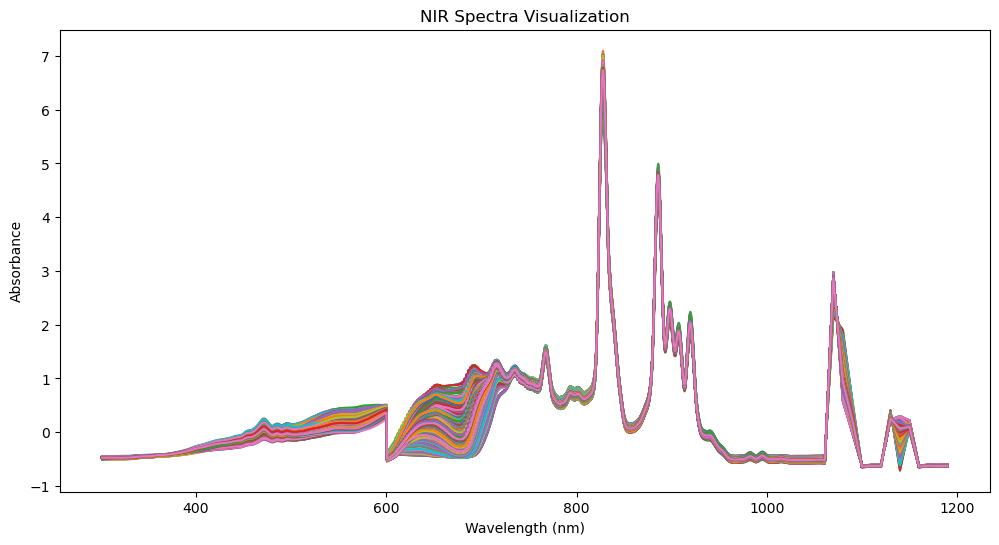

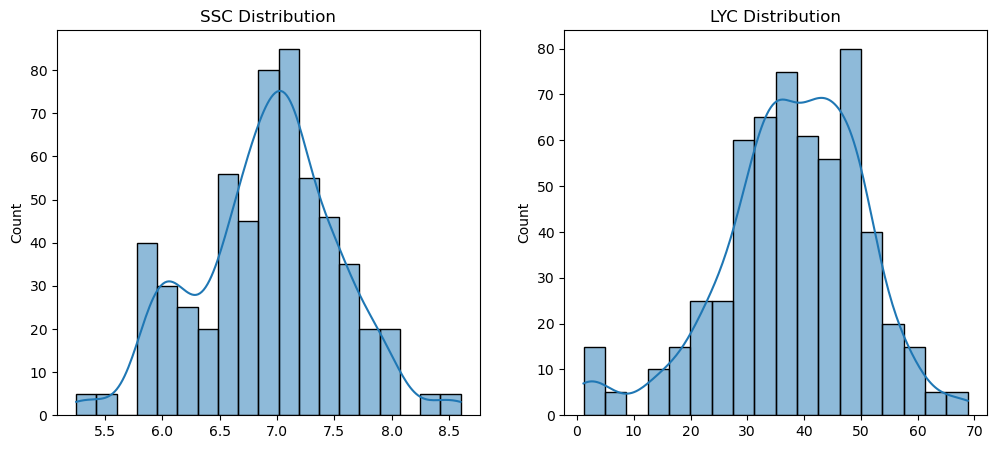

In [3]:
# 数据可视化

# 光谱数据可视化
plt.figure(figsize=(12, 6))
plt.plot(Z, X.T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('NIR Spectra Visualization')
plt.show()

# 目标变量分布可视化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(Y1, kde=True, ax=ax[0])
ax[0].set_title('SSC Distribution')
sns.histplot(Y2, kde=True, ax=ax[1])
ax[1].set_title('LYC Distribution')
plt.show()

In [4]:
# 数据集划分

# 初始划分训练集和测试集

YQ = np.reshape(YQ, (-1, 1))
Y = np.hstack((Y, YQ))
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED
)

Y_trainQ = Y_train[:, 2]  # 获取 Y_train 的第三列
Y_train = Y_train[:, 0:2]  # 获取 Y_train 的前两列

Y_testQ = Y_test[:, 2]  # 获取 Y_test 的第三列
Y_test = Y_test[:, 0:2]  # 获取 Y_test 的前两列

# 数据标准化
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(Y_train)

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
Y_train = y_scaler.transform(Y_train)
Y_test = y_scaler.transform(Y_test)

In [5]:
# 神经网络模型定义

class MultiOutputNN(nn.Module):
    """
    多输出神经网络结构
    参数说明：
    - input_dim: 输入特征维度
    - output_dim: 输出目标数量
    - hidden_dims: 隐藏层维度列表（示例：[64, 32] 表示两个隐藏层）
    - dropout_rate: Dropout比例
    """
    def __init__(self, input_dim, output_dim=2, hidden_dims=[128, 32], dropout_rate=0.2):
        super().__init__()
        layers = []
        in_dim = input_dim
        
        # 动态构建隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = h_dim
            
        self.feature_extractor = nn.Sequential(*layers)
        self.regressor = nn.Linear(in_dim, output_dim)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.regressor(features)

In [6]:
# 训练准备函数

def train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion,
    optimizer,
    n_epochs=200,
    patience=20
):
    """
    模型训练函数
    返回：
    - 训练好的模型
    - 训练损失历史
    - 验证损失历史
    """
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    no_improve = 0
    
    for epoch in range(n_epochs):
        # 训练阶段
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # 验证阶段
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                
        # 记录损失
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # 早停机制
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    return model, train_losses, val_losses

In [9]:
# 定义参数搜索空间
params_grid = {
#     'hidden_dims': [[68, 32], [128, 64]],  # 隐藏层结构选项
#     'dropout_rate': [0.25, 0.3, 0.35],                      # dropout率选项
#     'batch_size': [32, 64, 128],                          # 批大小选项
#     'learning_rate': [0.001, 0.0001],                     # 学习率选项
#     'weight_decay': [0.001],                     # L2正则化系数选项
    
    'hidden_dims': [[128, 64]],  # 隐藏层结构选项
    'dropout_rate': [0.35],                      # dropout率选项
    'batch_size': [128],                          # 批大小选项
    'learning_rate': [ 0.0001],                     # 学习率选项
    'weight_decay': [0.001],                     # L2正则化系数选项
    
}

# 生成所有参数组合
from sklearn.model_selection import ParameterGrid
param_combinations = list(ParameterGrid(params_grid))

# 固定参数
fixed_params = {
    'input_dim': X_train.shape[1],
    'scheduler_factor': 0.5,
    'scheduler_patience': 10,
    'n_epochs': 800,
    'patience': 50
}

# 存储最佳结果
best_score = -np.inf
best_params = None
best_metrics = []

# 参数搜索主循环
for param_combo in param_combinations:
    current_params = {**fixed_params, **param_combo}
    print(f"\nTesting parameters: {current_params}")
    
    fold_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # 五折交叉验证
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        # 数据准备
        X_tr, Y_tr = X_train[train_idx], Y_train[train_idx]
        X_val, Y_val = X_train[val_idx], Y_train[val_idx]
        
        # 创建DataLoader
        train_loader = DataLoader(
            TensorDataset(torch.tensor(X_tr), torch.tensor(Y_tr)),
            batch_size=current_params['batch_size'],
            shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(torch.tensor(X_val), torch.tensor(Y_val)),
            batch_size=current_params['batch_size']
        )
        
        # 模型初始化
        model = MultiOutputNN(
            input_dim=current_params['input_dim'],
            hidden_dims=current_params['hidden_dims'],
            dropout_rate=current_params['dropout_rate']
        ).to(device)
        
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=current_params['learning_rate'],
            weight_decay=current_params['weight_decay']
        )
        
        # 训练过程
        trained_model, _, _ = train_model(
            model, train_loader, val_loader,
            criterion=nn.MSELoss(),
            optimizer=optimizer,
            n_epochs=current_params['n_epochs'],
            patience=current_params['patience']
        )
        
        # 验证集评估
        with torch.no_grad():
            y_val_pred = trained_model(torch.tensor(X_val).float().to(device)).cpu().numpy()
        
        # 反标准化
        y_val_true = y_scaler.inverse_transform(Y_val)
        y_val_pred = y_scaler.inverse_transform(y_val_pred)
        
        # 计算RPDV
        rpd_scores = []
        for i in range(y_val_true.shape[1]):
            rmse = np.sqrt(mean_squared_error(y_val_true[:, i], y_val_pred[:, i]))
            rpd = np.std(y_val_true[:, i]) / rmse
            rpd_scores.append(rpd)
        
        fold_score = sum(rpd_scores)  # 综合两个指标的RPD
        fold_scores.append(fold_score)
    
    # 计算平均得分
    mean_score = np.mean(fold_scores)
    print(f"Average RPDV sum: {mean_score:.2f}")
    
    # 更新最佳参数
    if mean_score > best_score:
        best_score = mean_score
        best_params = current_params
        best_metrics = fold_scores

print("\nBest Parameters:")
print(best_params)
print(f"Best Average RPDV sum: {best_score:.2f}")



Testing parameters: {'input_dim': 1831, 'scheduler_factor': 0.5, 'scheduler_patience': 10, 'n_epochs': 800, 'patience': 50, 'batch_size': 128, 'dropout_rate': 0.35, 'hidden_dims': [128, 64], 'learning_rate': 0.0001, 'weight_decay': 0.001}
Early stopping at epoch 312
Early stopping at epoch 380
Early stopping at epoch 348
Early stopping at epoch 610
Average RPDV sum: 4.01

Best Parameters:
{'input_dim': 1831, 'scheduler_factor': 0.5, 'scheduler_patience': 10, 'n_epochs': 800, 'patience': 50, 'batch_size': 128, 'dropout_rate': 0.35, 'hidden_dims': [128, 64], 'learning_rate': 0.0001, 'weight_decay': 0.001}
Best Average RPDV sum: 4.01


In [10]:
# 全训练集训练最终模型

# 准备完整训练数据
full_train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train), 
        torch.tensor(Y_train)
    ),
    batch_size=best_params['batch_size'], 
    shuffle=True
)

# 初始化最终模型
final_model = MultiOutputNN(
    input_dim=best_params['input_dim'],
    hidden_dims=best_params['hidden_dims'],
    dropout_rate=best_params['dropout_rate']
).to(device)

optimizer = torch.optim.Adam(
    final_model.parameters(), 
    lr=best_params['learning_rate']
)
criterion = nn.MSELoss()

# 训练最终模型
final_model, train_loss, val_loss = train_model(
    final_model, full_train_loader, full_train_loader,  
    criterion, optimizer,
    n_epochs=best_params['n_epochs'],
    patience=best_params['patience']
)

Early stopping at epoch 761


In [12]:
# 测试集评估

# 测试集预测
with torch.no_grad():
    y_test_pred = final_model(torch.tensor(X_test).float().to(device)).cpu().numpy()
    y_train_pred = final_model(torch.tensor(X_train).float().to(device)).cpu().numpy()

# 反标准化
y_train_true = y_scaler.inverse_transform(Y_train)
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_true = y_scaler.inverse_transform(Y_test)
y_test_pred = y_scaler.inverse_transform(y_test_pred)


# 计算训练指标
test_metricsc = {}
test_metricsp = {}
for i, target in enumerate(['SSC', 'LYC']):
    # 计算各项指标
    r2c = r2_score(y_train_true[:, i], y_train_pred[:, i])
    rmsec = np.sqrt(mean_squared_error(y_train_true[:, i], y_train_pred[:, i]))
    rpdc = np.std(y_train_true[:, i]) / rmsec
    
    test_metricsc.update({
        f'{target}_R2C': r2c,
        f'{target}_RMSEC': rmsec,
        f'{target}_RPC': rpdc
    })

print("\nTrain Set Performance:")
print(pd.Series(test_metricsc))

# 计算测试指标
test_metricsp = {}
for i, target in enumerate(['SSC', 'LYC']):
    # 计算各项指标
    r2p = r2_score(y_test_true[:, i], y_test_pred[:, i])
    rmsep = np.sqrt(mean_squared_error(y_test_true[:, i], y_test_pred[:, i]))
    rpdp = np.std(y_test_true[:, i]) / rmsep
    
    test_metricsp.update({
        f'{target}_R2P': r2p,
        f'{target}_RMSEP': rmsep,
        f'{target}_RPD': rpdp
    })

print("\nTest Set Performance:")
print(pd.Series(test_metricsp))


Train Set Performance:
SSC_R2C      0.929851
SSC_RMSEC    0.160188
SSC_RPC      3.775616
LYC_R2C      0.889062
LYC_RMSEC    4.000633
LYC_RPC      3.002343
dtype: float64

Test Set Performance:
SSC_R2P      0.875660
SSC_RMSEP    0.224714
SSC_RPD      2.835918
LYC_R2P      0.861689
LYC_RMSEP    5.236431
LYC_RPD      2.688882
dtype: float64


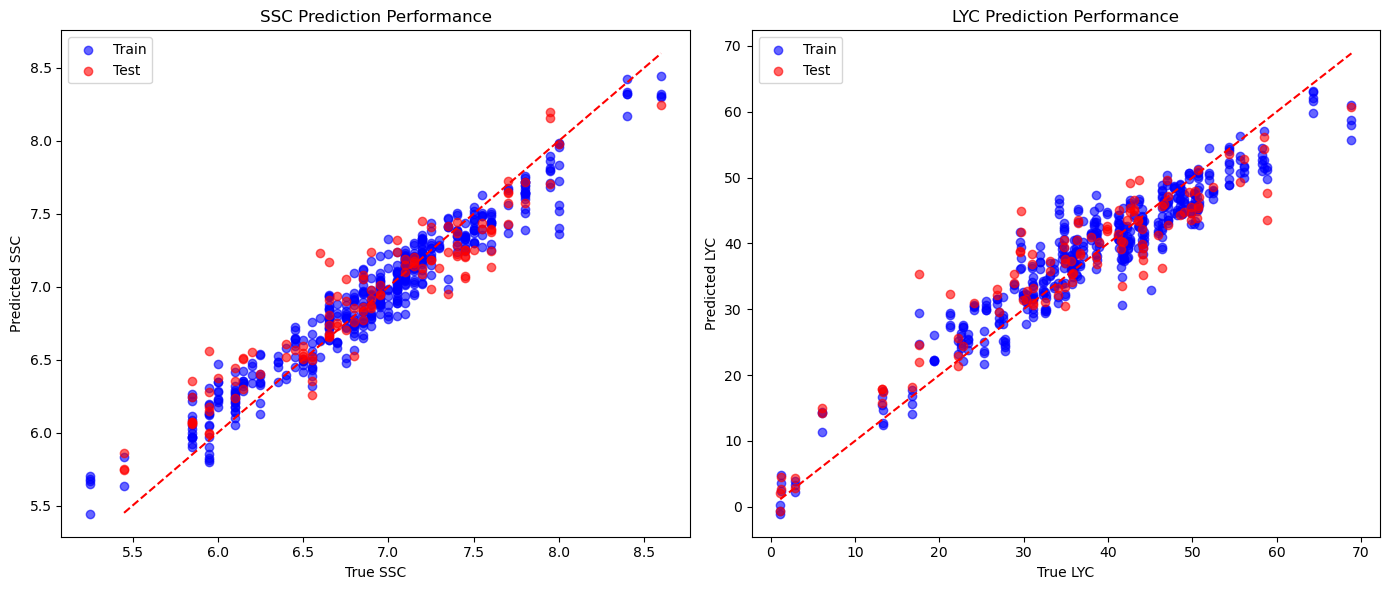

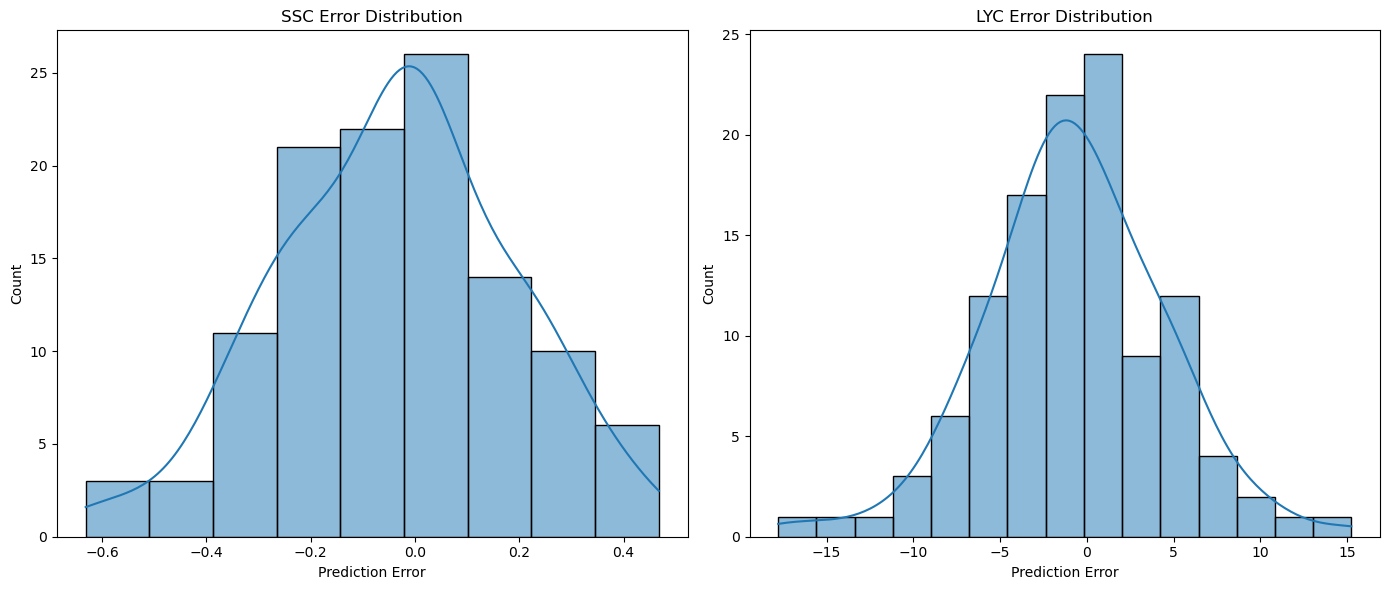

In [13]:
# 结果可视化

# 预测结果散点图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, target in enumerate(['SSC', 'LYC']):
    ax = axes[i]
    
    ax.scatter(y_train_true[:, i], y_train_pred[:, i], alpha=0.6, c='blue', label='Train')
    ax.scatter(y_test_true[:, i], y_test_pred[:, i], alpha=0.6, c='red',label='Test')
    ax.legend()
    ax.plot([min(y_test_true[:, i]), max(y_test_true[:, i])], 
            [min(y_test_true[:, i]), max(y_test_true[:, i])], 
            'r--')
    ax.set_xlabel(f'True {target}')
    ax.set_ylabel(f'Predicted {target}')
    ax.set_title(f'{target} Prediction Performance')
    
plt.tight_layout()
plt.show()

# 误差分布图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, target in enumerate(['SSC', 'LYC']):
    errors = y_test_true[:, i] - y_test_pred[:, i]
    sns.histplot(errors, kde=True, ax=axes[i])
    axes[i].set_title(f'{target} Error Distribution')
    axes[i].set_xlabel('Prediction Error')
plt.tight_layout()
plt.show()

In [14]:
# 保存数据
df_train = pd.DataFrame({
    'Train_SSC_True': y_train_true[:, 0],
    'Train_SSC_Pred': y_train_pred[:, 0],
    'Train_LYC_True': y_train_true[:, 1],
    'Train_LYC_Pred': y_train_pred[:, 1]
})

df_test = pd.DataFrame({
    'Test_SSC_True': y_test_true[:, 0],
    'Test_SSC_Pred': y_test_pred[:, 0],
    'Test_LYC_True': y_test_true[:, 1],
    'Test_LYC_Pred': y_test_pred[:, 1]
})

# 保存到 Excel 文件
with pd.ExcelWriter('ANN-2-results.xlsx') as writer:
    df_train.to_excel(writer, sheet_name='Train_Predictions', index=False)
    df_test.to_excel(writer, sheet_name='Test_Predictions', index=False)


In [15]:
# 计算模型性能

# 转换 Y_train_pred
y_train_pred1 = np.zeros_like(y_train_pred)
y_test_pred1  = np.zeros_like(y_test_pred)

y_train_pred1[:, 0] = (y_train_pred[:, 0] - 5.25) / (8.6 - 5.25)
y_train_pred1[:, 1] = (y_train_pred[:, 1] - 1.142857) / (68.857 - 1.142857)

# 转换 Y_test_pred
y_test_pred1[:, 0] = (y_test_pred[:, 0] - 5.25) / (8.6 - 5.25)
y_test_pred1[:, 1] = (y_test_pred[:, 1] - 1.142857) / (68.857 - 1.142857)

# 计算 Y_train_predQ
y_train_predQ = (y_train_pred1[:, 0] * Q[0] + y_train_pred1[:, 1] * Q[1]) * 10
# 计算 Y_test_predQ
y_test_predQ = (y_test_pred1[:, 0] * Q[0] + y_test_pred1[:, 1] * Q[1]) * 10



# 计算 R2CQ, RMSECQ
R2CQ = 1 - np.sum((Y_trainQ - y_train_predQ)**2) / np.sum((Y_trainQ - np.mean(Y_trainQ))**2)
RMSECQ = np.sqrt(np.mean((Y_trainQ - y_train_predQ)**2))

# 计算 R2VQ, RMSEPQ
R2VQ = 1 - np.sum((Y_testQ - y_test_predQ)**2) / np.sum((Y_testQ - np.mean(Y_testQ))**2)
RMSEPQ = np.sqrt(np.mean((Y_testQ - y_test_predQ)**2))

# 计算 SD_YQ, RPDQ
SD_YQ = np.std(Y_testQ)
RPDQ = SD_YQ / RMSEPQ

# 打印结果
print(f'Q - R² (训练集): {R2CQ:.3f}, RMSEC: {RMSECQ:.3f}')
print(f'Q - R² (测试集): {R2VQ:.3f}, RMSEP: {RMSEPQ:.3f}, RPD: {RPDQ:.3f}')


Q - R² (训练集): 0.861, RMSEC: 0.917
Q - R² (测试集): 0.822, RMSEP: 1.199, RPD: 2.368


In [19]:
# 保存结果
train_df = pd.DataFrame({
    'True_Q_Train': Y_trainQ,
    'Pred_Q_Train': y_train_predQ,
})

test_df = pd.DataFrame({
    'True_Q_Test': Y_testQ,
    'Pred_Q_Test': y_test_predQ,
})

# 保存到 Excel，不同数据存入不同 sheet
with pd.ExcelWriter('prediction_resultsQQQ.xlsx') as writer:
    train_df.to_excel(writer, sheet_name='Train Data', index=False)
    test_df.to_excel(writer, sheet_name='Test Data', index=False)

print("数据已成功导出到 prediction_resultsQQQ.xlsx")


数据已成功导出到 prediction_resultsQQQ.xlsx
